### Bayesian

Computational Bayesian statistics

The primary goal is to infer the posterior of the parameters theta of some model given the observations or data $D = {y_1, ..., y_n}$ iid

$p(\theta|D) = \frac{p(\theta) p(D|\theta)}{p(D)}$, $p(D|\theta) = \prod_{n=1}^N p(y_n|\theta)$, $p(D|\theta) = \prod_{n=1}^N p(y_n|x_n;\theta)$

In [ ]:
%matplotlib inline
import sklearn
import scipy.stats as stats
import scipy.optimize
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
import os
import pandas as pd

In [ ]:
!pip install pymc > /dev/null/
import pymc as pm
pm.__version__
!pip install arviz > /dev/null/
import arviz as az

/bin/bash: line 1: /dev/null/: Is a directory
/bin/bash: line 1: /dev/null/: Is a directory


#### Beta-Binomial model

Exact inference

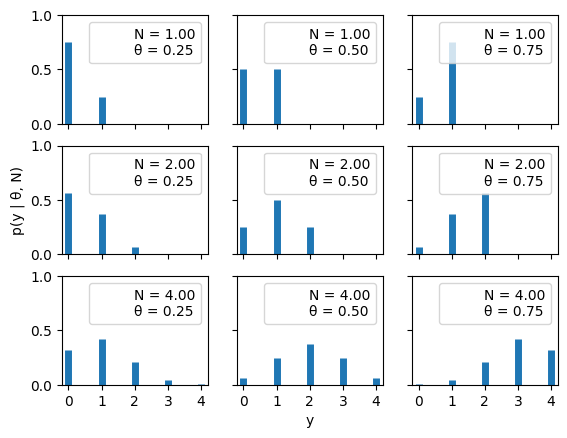

In [ ]:
''' Plot the Binomial likelihood '''
n_params = [1, 2, 4]
p_params = [0.25, 0.5, 0.75]
x = np.arange(0, max(n_params) + 1)
f, ax = plt.subplots(
    len(n_params), len(p_params), sharex=True, sharey=True,)

for i in range(len(n_params)):
    for j in range(len(p_params)):
        n = n_params[i]
        p = p_params[j]

        y = stats.binom(n=n, p=p).pmf(x)

        ax[i, j].vlines(x, 0, y, colors="C0", lw=5)
        ax[i, j].set_ylim(0, 1)
        ax[i, j].plot(0, 0, label="N = {:3.2f}\nθ = {:3.2f}".format(n, p), alpha=0)
        ax[i, j].legend()

        ax[2, 1].set_xlabel("y")
        ax[1, 0].set_ylabel("p(y | θ, N)")
        ax[0, 0].set_xticks(x)

Text(0.07, 0.5, 'p(θ)')

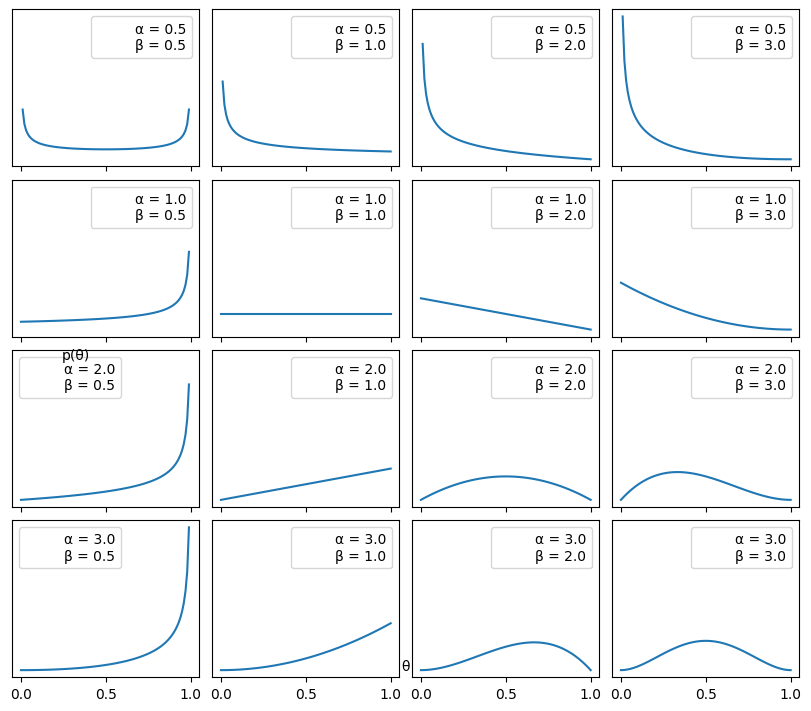

In [ ]:
''' Plot the beta prior '''
params = [0.5, 1, 2, 3]
x = np.linspace(0, 1, 100)
f, ax = plt.subplots(len(params), len(params), sharex=True, sharey=True, figsize=(8, 7), constrained_layout=True)

for i in range(4):
    for j in range(4):
        a = params[i]
        b = params[j]
        y = stats.beta(a, b).pdf(x)
        ax[i, j].plot(x, y)
        ax[i, j].plot(0, 0, label="α = {:2.1f}\nβ = {:2.1f}".format(a, b), alpha=0)
        ax[i, j].legend()

ax[1, 0].set_yticks([])
ax[1, 0].set_xticks([0, 0.5, 1])
f.text(0.5, 0.05, "θ", ha="center")
f.text(0.07, 0.5, "p(θ)", va="center", rotation=0)

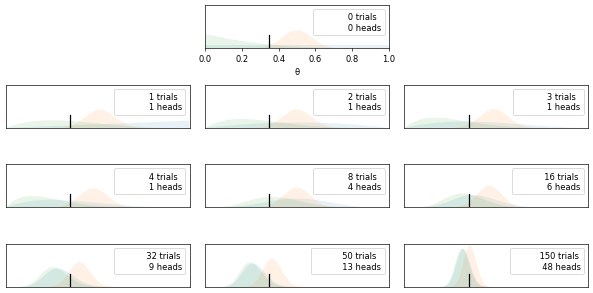

In [ ]:
''' Compute and plot posterior (black vertical line = true parameter value) '''
plt.figure(figsize=(10, 5), dpi=60)

n_trials = [0, 1, 2, 3, 4, 8, 16, 32, 50, 150]
data = [0, 1, 1, 1, 1, 4, 6, 9, 13, 48]
theta_real = 0.35

beta_params = [(1, 1), (20, 20), (1, 4)]
dist = stats.beta
x = np.linspace(0, 1, 200)

for idx, N in enumerate(n_trials):
    if idx == 0:
        plt.subplot(4, 3, 2)
        plt.xlabel("θ")
    else:
        plt.subplot(4, 3, idx + 3)
        plt.xticks([])
    y = data[idx]
    for (a_prior, b_prior) in beta_params:
        p_theta_given_y = dist.pdf(x, a_prior + y, b_prior + N - y)
        plt.fill_between(x, 0, p_theta_given_y, alpha=0.1)

    plt.axvline(theta_real, ymax=0.3, color="k")
    plt.plot(0, 0, label=f"{N:4d} trials\n{y:4d} heads", alpha=0)
    plt.xlim(0, 1)
    plt.ylim(0, 12)
    plt.legend()
    plt.yticks([])
plt.tight_layout()

#### Credible intervals

In [ ]:
from scipy.stats import beta

np.random.seed(42)
theta_real = 0.35
ntrials = 100
data = stats.bernoulli.rvs(p=theta_real, size=ntrials)

N = ntrials
N1 = sum(data)
N0 = N - N1
''' sufficient statistics '''
aprior = 1
bprior = 1
apost = aprior + N1
bpost = bprior + N0

''' interval function '''
alpha = 0.05
CI1 = beta.interval(1 - alpha, apost, bpost)
print("{:0.2f}--{:0.2f}"
.format(CI1[0], CI1[1])) # (0.06:0.52)

''' use the inverse CDF (percent point function) '''
l = beta.ppf(alpha / 2, apost, bpost)
u = beta.ppf(1 - alpha / 2, apost, bpost)
CI2 = (l, u)
print("{:0.2f}--{:0.2f}".format(CI2[0], CI2[1])) # (0.06:0.52)

''' use Monte Carlo sampling '''
samples = beta.rvs(apost, bpost, size=10000)
samples = np.sort(samples)
CI3 = np.percentile(samples, 100 * np.array([alpha / 2, 1 - alpha / 2]))
print("{:0.2f}--{:0.2f}".format(CI3[0], CI3[1])) # (0.06:0.51)
print(np.mean(samples))

0.24--0.42
0.24--0.42
0.24--0.42
0.3230834644012448


<Axes: title={'center': 'θ'}>

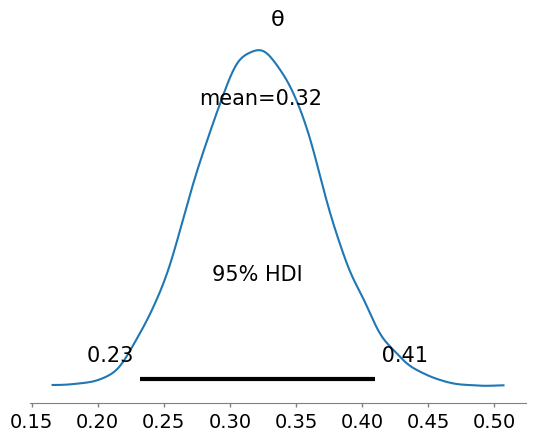

In [ ]:
az.plot_posterior({"θ": samples}, hdi_prob=0.95)

<Axes: title={'center': 'x'}>

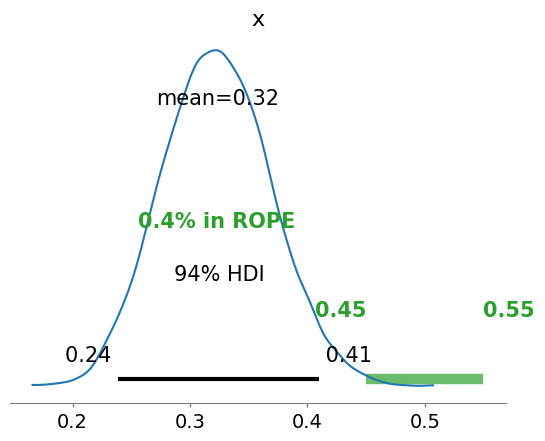

In [ ]:
az.plot_posterior(samples, rope=[0.45, 0.55])

<Axes: title={'center': 'x'}>

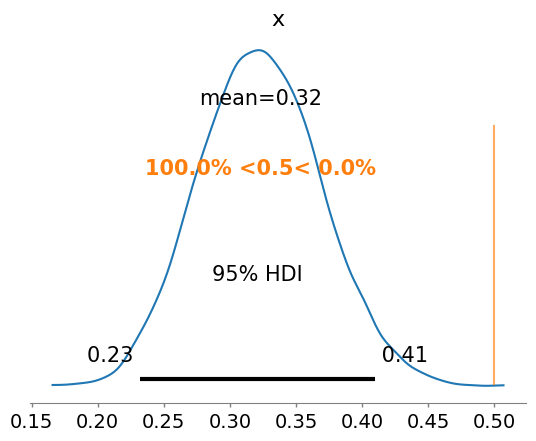

In [ ]:
az.plot_posterior(samples, hdi_prob=0.95, ref_val=0.5)

In [ ]:
az.summary(samples)

Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.323,0.046,0.239,0.41,0.041,0.01,1.0,10.0,NaN


Point Estimates

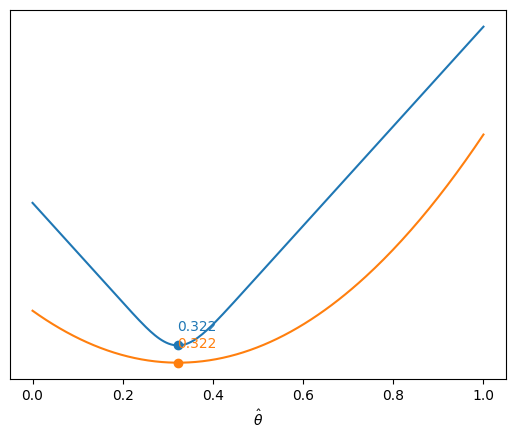

In [ ]:
'''
We minimize the posterior expected loss, using L2 loss (estimator is posterior mean) or L1 loss (estimator is posterior median)
'''
grid = np.linspace(0, 1, 200)
θ_pos = samples # trace['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos) ** 2) for i in grid]

for lossf, c in zip([lossf_a, lossf_b], ["C0", "C1"]):
    mini = np.argmin(lossf)
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], "o", color=c)
    plt.annotate("{:.3f}".format(grid[mini]), (grid[mini], lossf[mini] + 0.03), color=c)
    plt.yticks([])
    plt.xlabel(r"$\hat \theta$")

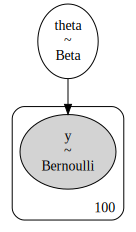

In [ ]:
with pm.Model() as model:
    theta = pm.Beta('theta', alpha=aprior, beta=bprior) # a priori
    y = pm.Bernoulli('y', p=theta, observed=data) # likelihood

pm.model_to_graphviz(model)

In [ ]:
with model:
    trace = pm.sample(1000, random_seed=123)

Output()

        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  0.322  0.044   0.237    0.402      0.001    0.001     946.0    1378.0   

       r_hat  
theta    1.0  


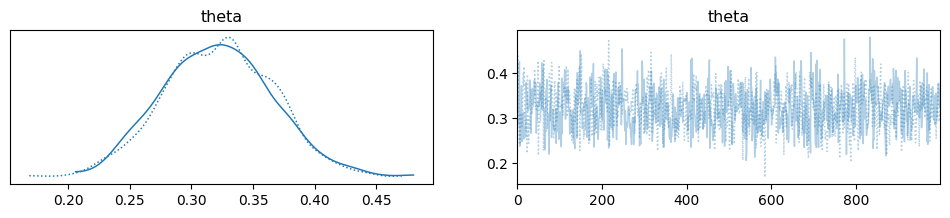

In [ ]:
''' MCMC diagnostics '''
az.plot_trace(trace)
#az.summary provides R-hat, ESS, and other diagnostics
diagnostics = az.summary(trace)
print(diagnostics)

<Axes: title={'center': 'theta'}>

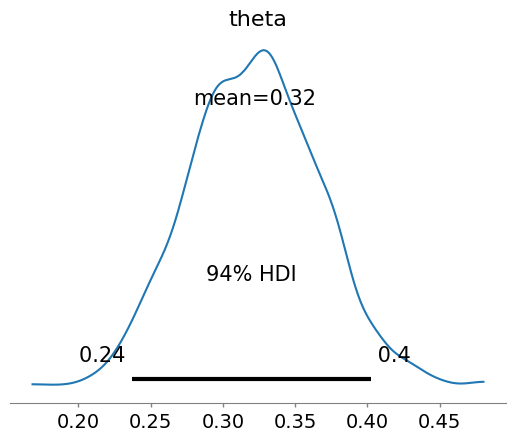

In [ ]:
pm.plot_posterior(trace)

In [ ]:
''' summary posterior samples '''
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.322,0.044,0.237,0.402,0.001,0.001,946.0,1378.0,1.0


<Axes: title={'center': 'theta'}>

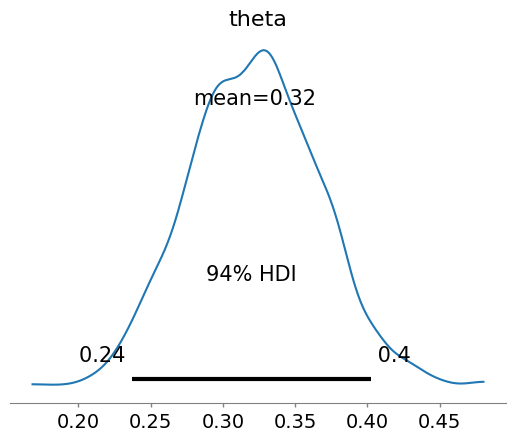

In [ ]:
''' Plot posterior samples directly from the trace '''
# Note: pm.Empirical is a legacy class that does not support InferenceData.
# We can achieve the same goal by plotting the trace directly with ArviZ.
az.plot_posterior(trace)

Variational inference

In [ ]:
niter = 10000
with model:
    post = pm.fit(niter, method='advi', random_seed=123)

Output()

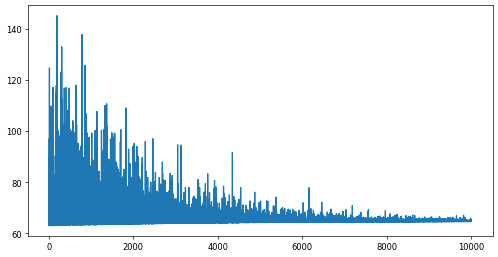

In [ ]:
''' plot negative ELBO vs iteration to asses convergence '''
plt.figure(figsize=(10, 5), dpi=60)
plt.plot(post.hist)

### 1D Gaussian

Exact Inference

In [ ]:
''' assume variance is known, infer the mean '''
np.random.seed(0)
N = 100
x = np.random.randn(100)

''' parameters of prior '''
mu_prior = 1.1
sigma_prior = 1.2
sigma_prior_ = sigma_prior**2

''' parameters of likelihood '''
sigma_x = 1.3
sigma_x_ = sigma_x**2

''' Bayes rule for Gaussians '''
sigma_post_ = 1 / (1 / sigma_prior_ +  N / sigma_x_)
x_bar = np.mean(x)
mu_post = sigma_post_ * (1 / sigma_x_ * N * x_bar +1/sigma_prior_ * mu_prior)
f'{mu_post:0.3f}, {sigma_post_:0.3}'

'0.072, 0.0167'

MCMC Inference

Output()

<Axes: title={'center': 'mu'}>

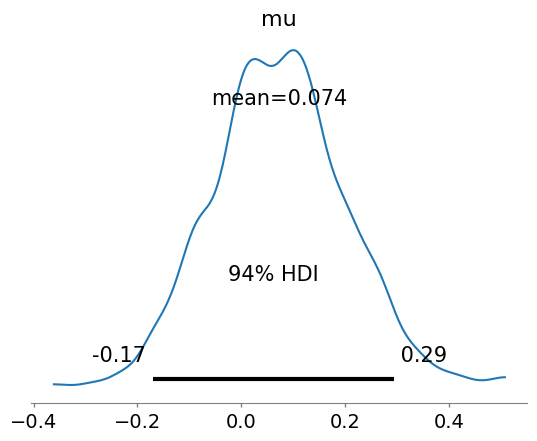

In [ ]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=mu_prior, sigma=sigma_prior)
    obs = pm.Normal('obs', mu=mu, sigma=sigma_x, observed=x)
    mcmc_samples = pm.sample(1000, tune=500)

az.plot_posterior(mcmc_samples)

In [ ]:
vals = mcmc_samples.posterior["mu"].values.flatten()
mu_post_mcmc = np.mean(vals)
sigma_post_mcmc = np.var(vals)
print("pMCMC(mu|D)=N(mu|{:.3f}, {:.3f})".format(mu_post_mcmc, sigma_post_mcmc))
assert np.isclose(mu_post, mu_post_mcmc, atol=1e-1)
assert np.isclose(sigma_post_, sigma_post_mcmc, atol=1e-1)

pMCMC(mu|D)=N(mu|0.074, 0.016)


([<matplotlib.axis.YTick at 0x7986cbf44ce0>], [Text(0, 0, '0')])

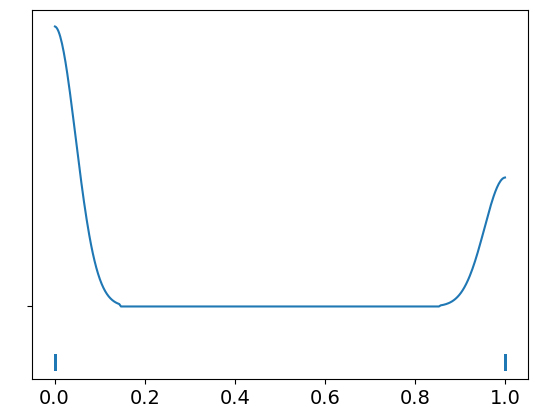

In [ ]:
az.plot_kde(data, rug=True)
plt.yticks([0], alpha=0)

[np.float64(-0.1), np.float64(1.1), np.float64(1.3939471963307817)]


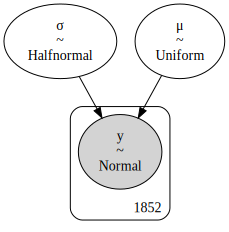

In [ ]:
'''
We will infer a posterior for the mean and variance. We use a uniform prior for the mean, with support slightly larger than the data. We use a truncated normal for the variance, with effective support uniform 0 to 3*std.
'''
r = np.max(data) - np.min(data)
min_mu = np.min(data) - 0.1 * r
max_mu = np.max(data) + 0.1 * r
prior_std = 3 * np.std(data)
print([min_mu, max_mu, prior_std])
with pm.Model() as model_g:
    μ = pm.Uniform("μ", lower=min_mu, upper=max_mu)
    σ = pm.HalfNormal("σ", sigma=10)
    y = pm.Normal("y", mu=μ, sigma=σ, observed=data)

pm.model_to_graphviz(model_g)

In [ ]:
with model_g:
    trace_g = pm.sample(1000, random_seed=123)

Output()

array([[<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

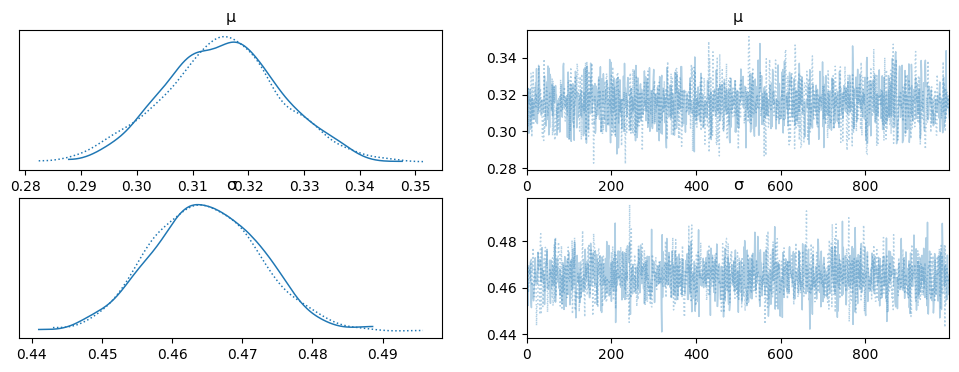

In [ ]:
az.plot_trace(trace_g)

In [ ]:
az.summary(trace_g)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,0.315,0.011,0.295,0.335,0.0,0.0,2090.0,1499.0,1.0
σ,0.465,0.008,0.450,0.479,0.0,0.0,2018.0,1716.0,1.0


array([[<Axes: >, None],
       [<Axes: xlabel='μ', ylabel='σ'>, <Axes: >]], dtype=object)

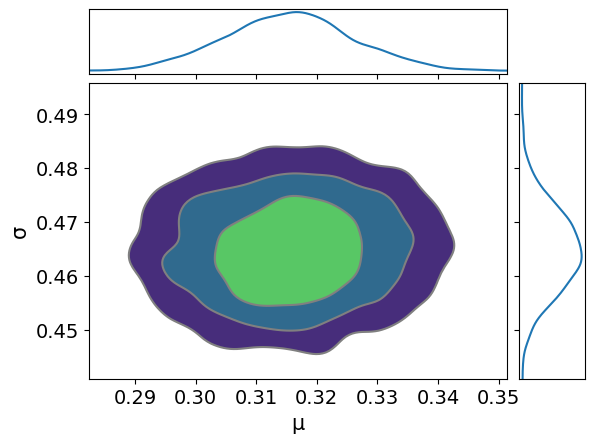

In [ ]:
az.plot_pair(trace_g, kind="kde", marginals=True)

Posterior predictive checks

In [ ]:
y_pred_g = pm.sample_posterior_predictive(trace_g, 100, model_g)
v = y_pred_g['y']
data_ppc = az.from_pymc(trace=trace_g, posterior_predictive=y_pred_g)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=False)
ax[0].legend(fontsize=15)